# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

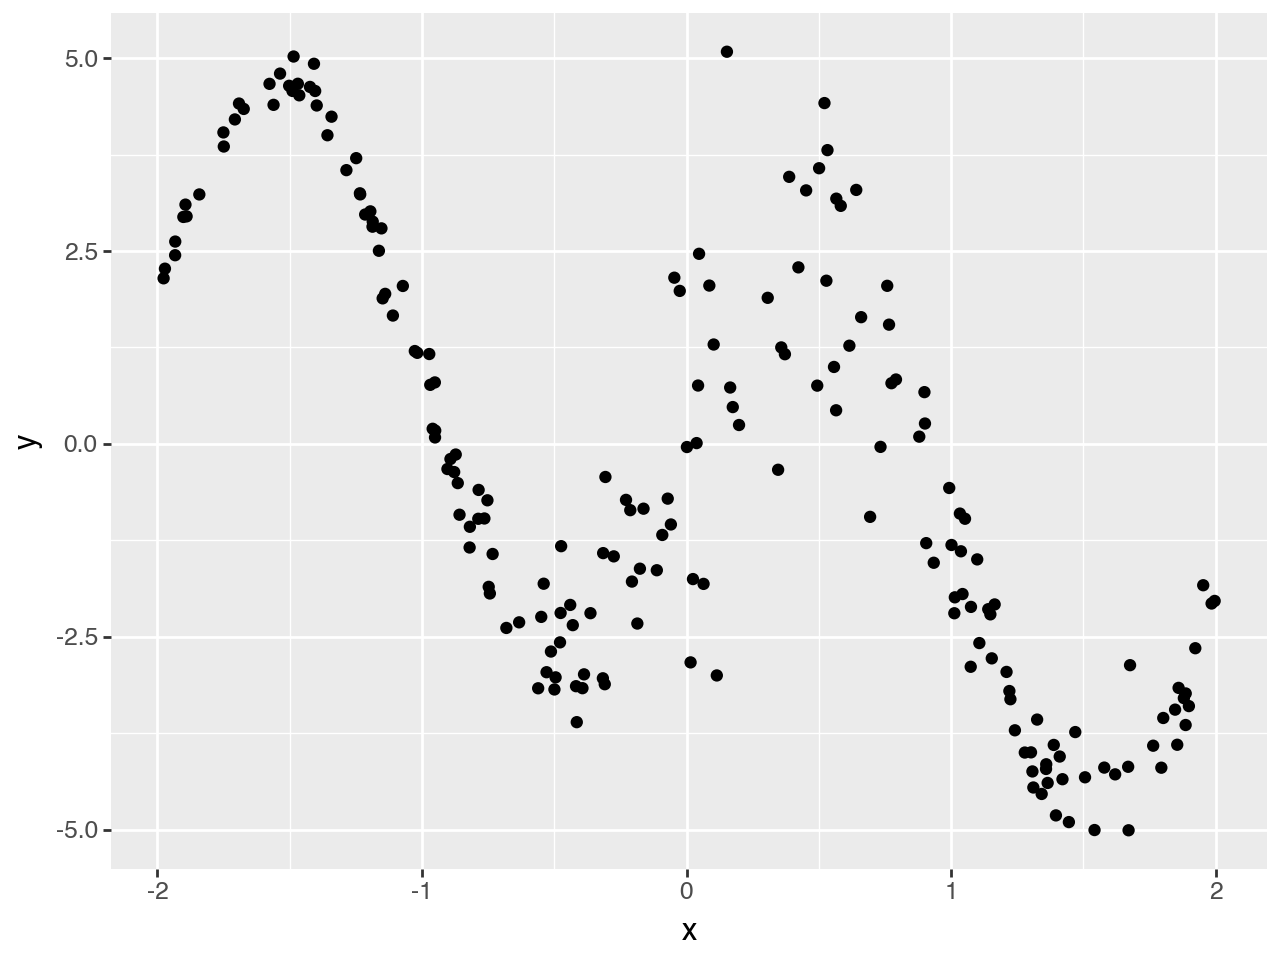

In [3]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

### Setup response model

In [4]:
loc = gam.AdditivePredictor("loc")
scale = gam.AdditivePredictor("scale", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.y.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)


registry = gam.PandasRegistry(df)
tbl = gam.TermBuilder(registry, prefix_names_by="loc.")
tbs = gam.TermBuilder(registry, prefix_names_by="scale.")

loc += tbl.np("x", k=20)
loc += tbl.lin("x")
scale += tbs.np("x", k=20)
scale += tbs.lin("x")

### Build and plot model

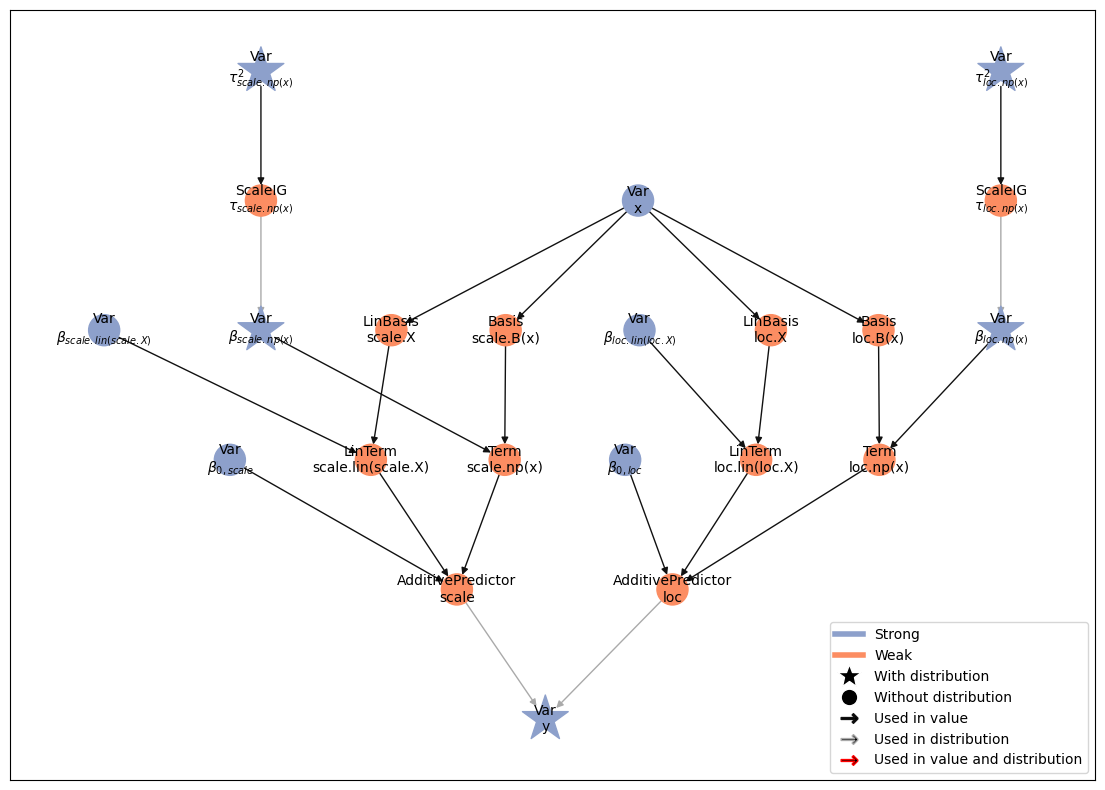

In [5]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [6]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,scale}$', '$\\beta_{scale.lin(scale.X)}$', '$\\beta_{scale.np(x)}$', '$\\tau^2_{scale.np(x)}$', '$\\beta_{0,loc}$', '$\\beta_{loc.lin(loc.X)}$', '$\\beta_{loc.np(x)}$', '$\\tau^2_{loc.np(x)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:05<00:00,  2.69chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 855.28chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████

### MCMC summary

In [15]:
summary = gs.Summary(results)
summary

Parameter summary:

                                       kernel      mean        sd    q_0.05  \
parameter                    index                                            
$\beta_{0,loc}$              ()     kernel_04 -0.264436  0.061745 -0.365219   
$\beta_{0,scale}$            ()     kernel_00 -0.643903  0.054108 -0.731988   
$\beta_{loc.lin(loc.X)}$     (0,)   kernel_05 -1.699472  0.029394 -1.748543   
$\beta_{loc.np(x)}$          (0,)   kernel_06 -0.023706  0.060332 -0.123549   
                             (1,)   kernel_06 -0.024263  0.052304 -0.110757   
                             (2,)   kernel_06 -0.059443  0.061103 -0.163756   
                             (3,)   kernel_06  0.006080  0.040548 -0.058938   
                             (4,)   kernel_06 -0.009449  0.058067 -0.105881   
                             (5,)   kernel_06  0.046286  0.040112 -0.018292   
                             (6,)   kernel_06 -0.023586  0.050994 -0.110038   
                             (7,)   kernel_06 -0.014537  0.048452 -0.094127   
                             (8,)   kernel_06  0.007321  0.033549 -0.046971   
                             (9,)   kernel_06 -0.011848  0.039202 -0.076655   
                             (10,)  kernel_06 -0.017749  0.027588 -0.062691   
                             (11,)  kernel_06 -0.020117  0.027276 -0.064213   
                             (12,)  kernel_06 -0.009530  0.020851 -0.043324   
                             (13,)  kernel_06  0.043093  0.015312  0.017927   
                             (14,)  kernel_06 -0.203011  0.012668 -0.223782   
                             (15,)  kernel_06  0.018871  0.007407  0.006931   
                             (16,)  kernel_06 -0.019583  0.004574 -0.027091   
                             (17,)  kernel_06 -0.000552  0.001539 -0.003116   
$\beta_{scale.lin(scale.X)}$ (0,)   kernel_01  0.308983  0.049898  0.227287   
$\beta_{scale.np(x)}$        (0,)   kernel_02 -0.032265  0.035109 -0.092035   
                             (1,)   kernel_02  0.014156  0.033196 -0.039230   
                             (2,)   kernel_02 -0.007919  0.036652 -0.069851   
                             (3,)   kernel_02  0.008996  0.037031 -0.049207   
                             (4,)   kernel_02  0.001074  0.035788 -0.055968   
                             (5,)   kernel_02 -0.001341  0.034151 -0.057421   
                             (6,)   kernel_02 -0.024537  0.034675 -0.083251   
                             (7,)   kernel_02  0.013003  0.031235 -0.036710   
                             (8,)   kernel_02  0.002951  0.029371 -0.044374   
                             (9,)   kernel_02  0.006695  0.027989 -0.038336   
                             (10,)  kernel_02 -0.005351  0.026118 -0.047567   
                             (11,)  kernel_02  0.003355  0.022810 -0.033874   
                             (12,)  kernel_02 -0.028013  0.019418 -0.060919   
                             (13,)  kernel_02  0.018930  0.016891 -0.008522   
                             (14,)  kernel_02 -0.002004  0.011886 -0.021519   
                             (15,)  kernel_02  0.012253  0.007840 -0.000545   
                             (16,)  kernel_02  0.001861  0.005209 -0.006652   
                             (17,)  kernel_02  0.007862  0.001821  0.004868   
$\tau^2_{loc.np(x)}$         ()     kernel_07  0.005027  0.002164  0.002544   
$\tau^2_{scale.np(x)}$       ()     kernel_03  0.001504  0.000778  0.000668   

                                       q_0.5    q_0.95  sample_size  \
parameter                    index                                    
$\beta_{0,loc}$              ()    -0.265912 -0.161649         4000   
$\beta_{0,scale}$            ()    -0.644690 -0.551597         4000   
$\beta_{loc.lin(loc.X)}$     (0,)  -1.699596 -1.651401         4000   
$\beta_{loc.np(x)}$          (0,)  -0.023983  0.074360         4000   
                             (1,)  -0.024493  0.059086         4000   
      

### MCMC trace plots

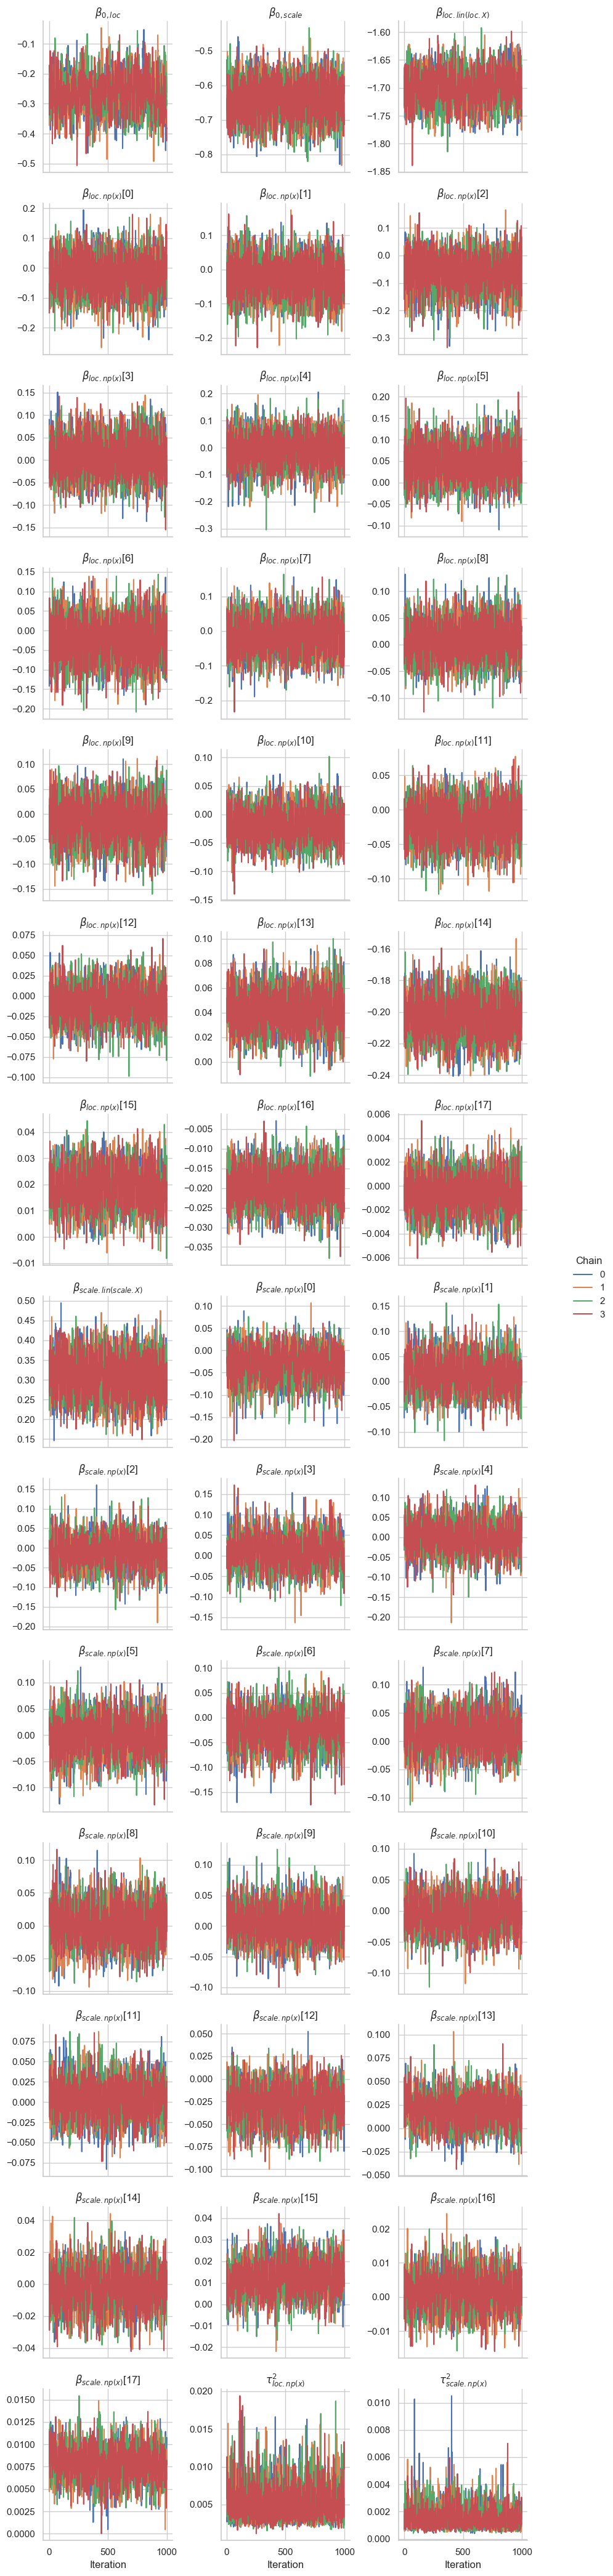

In [8]:
gs.plot_trace(results)

## Predictions

In [9]:
samples = results.get_posterior_samples()

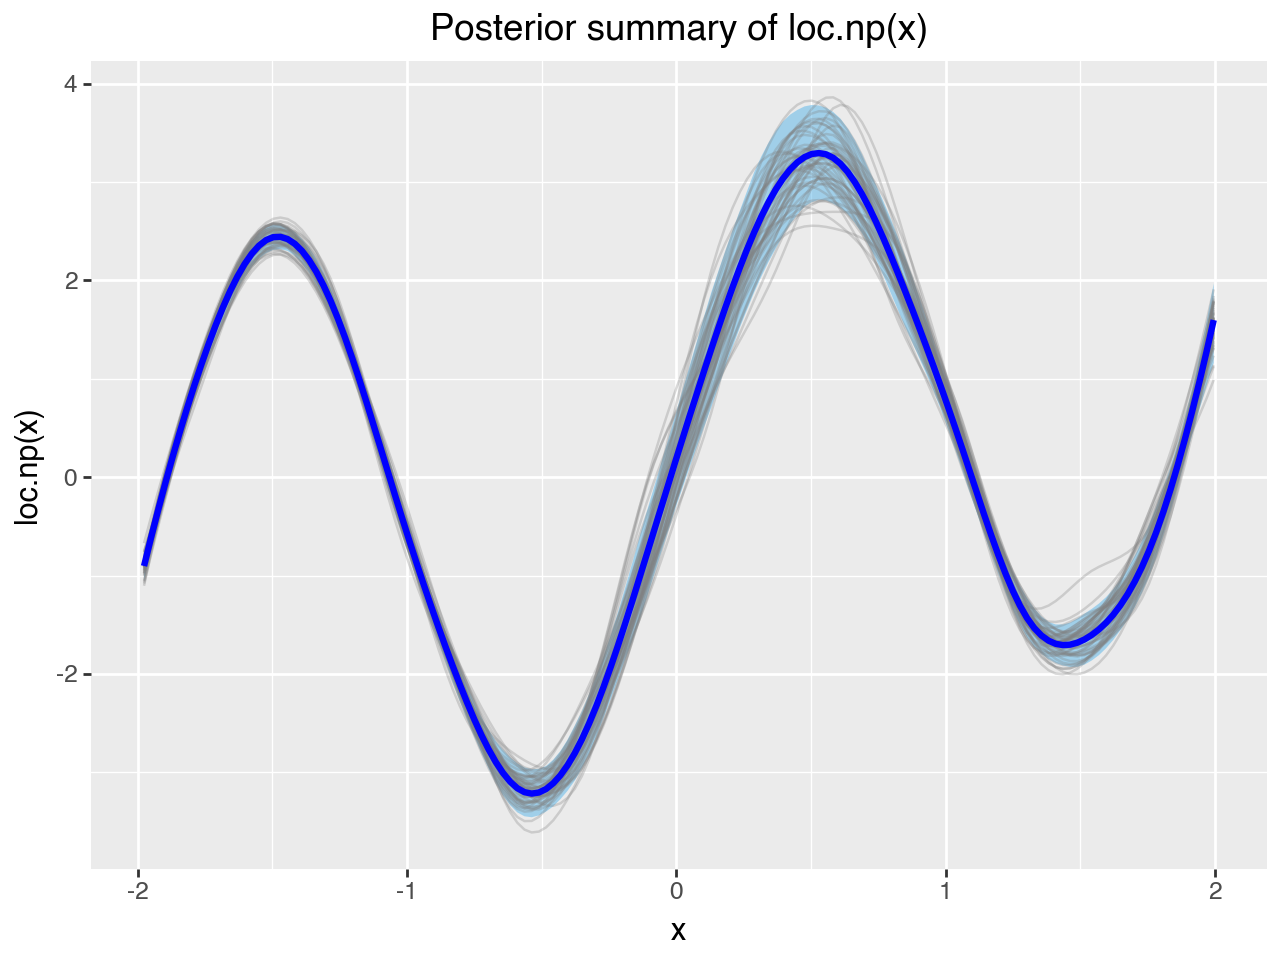

In [10]:
gam.plot_1d_smooth(term=model.vars["loc.np(x)"], samples=samples)

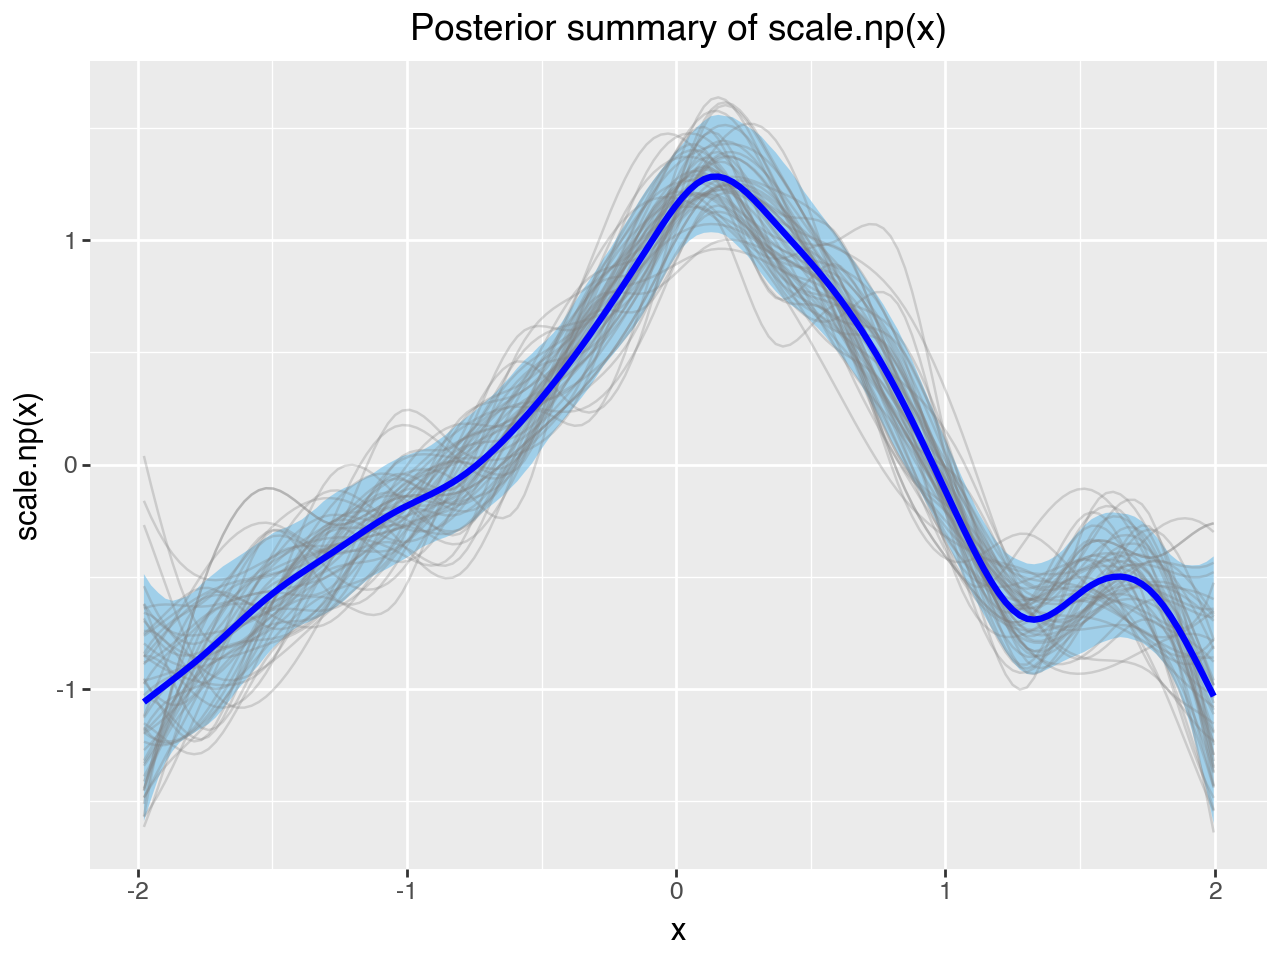

In [11]:
gam.plot_1d_smooth(term=model.vars["scale.np(x)"], samples=samples)